<h1><center>Лабораторна робота 5.</center></h1>
<h2><center>Логістична регресія й випадковий ліс в задачі кредитного скорингу</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="lab-5"></a>

## Зміст 

- [5.1. Завантаження навчальних даних](#lab-5.1)
- [5.2. Бутстреп](#lab-5.2)  
- [5.3. Підбір параметрів для моделі логістичної регресії](#lab-5.3)
- [5.4. Визначення впливу ознак](#lab-5.4)
- [5.5. Створення моделі випадкового лісу](#lab-5.5)
- [5.6. Беггінг](#lab-5.6)

Головним завданням цієї лабораторної роботи є побудова моделі на основі машинного навчання (МН) для задачі кредитного скорингу.

<a class="anchor" id="lab-5.1"></a>

## <span style="color:blue; font-size:1.2em;">5.1. Завантаження навчальних даних</span>

[Повернутися до змісту](#lab-5)

Змінна, значення якої прогнозується, $Y$:

 - SeriousDlqin2yrs – стан невиплати людиною кредиту впроводж наступних 90 днів; можливі значення: 1 – клієнт оплачує кредит із запізненням або не виплачує взагалі, 0 – клієнт оплачує кредит вчасно. 

Незалежні ознаки, $X$:

 - age – вік позичальника кредитних коштів; тип – integer;
 - NumberOfTime30-59DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більше 30-59 днів тому, але не більше впродовж останніх двох років; тип – integer;
 - DebtRatio – відношення щомісячного відрахування щодо заборгованості (кредити, аліменти тощо) до сукупного місячного доходу (percentage); тип – real;
 - MonthlyIncome – місячний дохід в доларах; тип – real;
 - NumberOfTimes90DaysLate – кількість прострочених виплат інших кредитів більше 90 днів; тип – integer;
 - NumberOfTime60-89DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більш 60-89 днів, але не більше впродовж останніх двох років; тип – integer;
 - NumberOfDependents – кількість членів сім'ї позичальника; тип – integer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
# Задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

Створимо функцію, яка буде замінювати NaN значення на медіану в кожному стовпчику таблиці:

In [3]:
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Завантажуємо дані для подальшого навчання:

In [4]:
credit_scoring_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-05_logit-rf-credit-scoring/credit_scoring_sample.csv'

data = pd.read_csv(credit_scoring_url, sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Розглянемо типи завантажених даних:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Переглянемо розподіл класів у цільовій змінні:

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

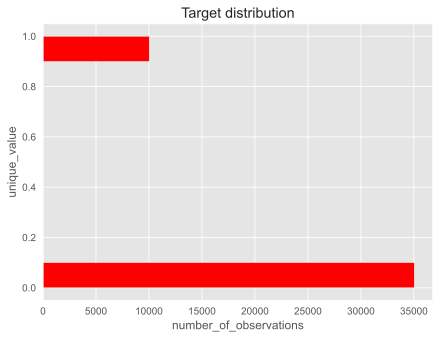

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Далі виберемо назви всіх ознак з таблиці, крім прогнозованого.

In [7]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Застосовуємо функцію, яка замінює всі NaN значення на медіанне значення відповідного стовпця.

In [8]:
table = delete_nan(data)

Розділяємо підготовлений набір даних на незалежні ознаки ($X$) та цільову ознаку ($y$).

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

<a class="anchor" id="lab-5.2"></a>

## <span style="color:blue; font-size:1.2em;">5.2. Бутстреп</span>

[Повернутися до змісту](#lab-5)

Спершу обрахуйте інтервальну оцінку середнього віку (age) для надійних клієнтів та тих клієнтів, що прострочили виплату кредиту з "впевненістю" >= 90% . Використайте приклад з лекції, поставте `np.random.seed (0)`, як це зроблено в огляді.

In [10]:
# Допоміжна функція для генерації підвибірок за допомогою бутстрепу
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

### <span style="color:red; font-size:1.5em;">Завдання 1</span>


**Для варіантів 1-2:**

Обрахуйте інтервальну оцінку медіанного доходу надійних клієнтів при `n_samples=500` та `alpha=0.05`.

**Для варіантів 3-4:**

Оцініть середню кількість відкритих кредитних ліній для боржників при `n_samples=1000` та `alpha=0.1`.

**Для варіантів 5-6:**

Обрахуйте інтервальну оцінку для середнього віку клієнтів без прострочень при `n_samples=700` та `alpha=0.05`.

**Для варіантів 7-8:**

Обрахуйте середній коефіцієнт використання відновлювальної незабезпеченої лінії для надійних клієнтів з `n_samples=800` та `alpha=0.1`.

**Для варіантів 9-10:**

Оцініть частку клієнтів з кредитами на нерухомість серед надійних клієнтів при `n_samples=1000` та `alpha=0.05`.

**Для варіантів 11-12:**

Обрахуйте інтервальну оцінку середньої кількості утриманців серед боржників при `n_samples=600` та `alpha=0.1`.

**Для варіантів 13-14:**

Обрахуйте інтервальну оцінку середнього доходу клієнтів, які не мають прострочень, при n_вибірок=500` та альфа=0.05`.

**Для варіантів 15-16:**

Оцініть медіанний вік клієнтів, які мають понад 3 відкритих кредитних ліній, при `n_samples=700` та `alpha=0.1`.

**Для варіантів 17-18:**

Обрахуйте середній коефіцієнт використання незабезпечених кредитів для клієнтів, які мають утриманців, з `n_samples=1000` та `alpha=0.05`.

**Для варіантів 19-20:**

Обрахуйте частку клієнтів, які мають понад 50% відновлювальної заборгованості серед боржників, з `n_samples=800` та `alpha=0.1`.


<a class="anchor" id="lab-5.3"></a>

## <span style="color:blue; font-size:1.2em;">5.3. Підбір параметрів для моделі логістичної регресії</span>

[Повернутися до змісту](#lab-5)

Однією з важливих метрик якості моделі є значення площі під [ROC-кривої](https://uk.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0) (AUC). Значення ROC-AUC лежить від 0 до 1. Чим ближче значення метрики ROC-AUC до 1, тим якісніше відбувається класифікація моделлю.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Використовуємо модуль [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) для побудови логістичної регресії. Через незбалансованість класів в цільовій функції додаємо параметр балансування. Також додамо параметр `random_state=5` для відтворюваності результатів.

In [12]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

Тепер спробуємо підібрати найкращий коефіцієнт регуляризації (коефіцієнт C в логістичній регресії) для моделі логістичної регрессії. Найкраще значення параметра С забезпечить нам оптимальність моделі, яка буде добре прогнозувати значення цільової функції і водночас не буде перенавчатися. Інші параметри залишаємо за замовчуванням.

In [13]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

Щоби підібрати коефіцієнт регуляризації переглянемо значення ROC-AUC на Stratified крос-валідації з 5 фолдів для кожного можливого значення коефіцієнта регуляризації за допомогою функції StratifiedKFold.

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Далі для розв'язку наступного завдання використайте [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) з метрикою ROC-AUC за параметром C.

### <span style="color:red; font-size:1.5em;">Завдання 2</span>


**Для варіантів 1-2:**

Знайдіть оптимальне значення параметра `max_depth` в моделі випадкового лісу за допомогою GridSearchCV.

**Для варіантів 3-4:**

Визначте оптимальну кількість оцінок у моделі випадкового лісу за допомогою GridSearchCV.

**Для варіантів 5-6:**

Визначте оптимальне значення параметра регуляризації в логістичній регресії за допомогою GridSearchCV.

**Для варіантів 7-8:**

Порівняйте середньоквадратичне відхилення оцінки точності в моделях логістичної регресії з результатами GridSearchCV.

**Для варіантів 9-10:**

Чи є найкраща модель логістичної регресії стабільною? Вважайте модель стабільною, якщо її валідаційне стандартне відхилення менш як 0.4%.

**Для варіантів 11-12:**

Визначте точність найкращої моделі випадкового лісу, використовуючи оптимальний параметр `max_features` з GridSearchCV.

**Для варіантів 13-14:**

Знайдіть оптимальну швидкість навчання для класифікатора з градієнтним підсиленням за допомогою GridSearchCV.

**Для варіантів 15-16:**

Яке оптимальне значення параметра `n_neighbors` у класифікаторі K-Nearest Neighbors за допомогою GridSearchCV?

**Для варіантів 17-18:**

Визначте оптимальне значення параметра `min_samples_split` для моделі дерева рішень за допомогою GridSearchCV.

**Для варіантів 19-20:**

Порівняйте стандартне відхилення оцінок ROC AUC в моделях випадкових лісів з результатами GridSearchCV.


***Примітка:*** для розв'язання завдання 2 скористайтесь атрибутами `GridSearchCV()` під назвою `grid_search.best_estimator_`, `grid_search.cv_results_`, `grid_search.best_score_`.

<a class="anchor" id="lab-5.4"></a>

## <span style="color:blue; font-size:1.2em;">5.4. Визначення впливу ознак</span>

[Повернутися до змісту](#lab-5)

У цьому завданні ми попрацюємо з важливістю ознак. Пам'ятаємо, що важливість ознаки визначається **абсолютним значенням її коефіцієнта**. Крім того, потрібно заздалегідь нормалізувати всі ознаки, щоб їх правильно порівняти.

In [15]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001,random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

Обрахуємо важливість ознак:

In [16]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


### <span style="color:red; font-size:1.5em;">Завдання 3</span>


**Для варіантів 1-2:**

Розрахуйте розмір впливу ознаки `NumberOfDependents` на цільову ознаку за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

**Для варіантів 3-4:**

Оцініть частку впливу фактору `MonthlyIncome` за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

**Для варіантів 5-6:**

У скільки разів збільшиться ймовірність дефолту, якщо кількість відкритих кредитних ліній збільшиться на 2 при незмінності інших факторів?

**Для варіантів 7-8:**

Розрахуйте вплив збільшення віку на 5 років на ймовірність дефолту при незмінності інших факторів.

**Для варіантів 9-10:**

Визначте вплив ознаки `NumberOfTime30-59DaysPastDueNotWorse` за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

**Для варіантів 11-12:**

Оцініть вплив збільшення револьверного використання незабезпечених ліній на 10% на ймовірність дефолту.

**Для варіантів 13-14:**

Розрахуйте вплив на ймовірність дефолту ще одного кредиту на нерухомість.

**Для варіантів 15-16:**

Визначте частку впливу фактору `NumberOfTimes90DaysLate` за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

**Для варіантів 17-18:**

Оцініть вплив зменшення кількості утриманців на 1 на ймовірність дефолту.

**Для варіантів 19-20:**

Розрахуйте вплив ознаки `NumberRealEstateLoansOrLines` на цільовий показник за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).


In [17]:
# Ваш код тут

***Примітка 1:*** Приклад реалізації функції softmax можете підчитати [тут](https://machinelearningmastery.com/softmax-activation-function-with-python/).

***Примітка 2:***

Формула, за якою обраховують у скільки разів збільшаться шанси при підвищенні знчення ознаки:

$$ \large \exp^{\beta\delta}, $$

де

$ \beta $ – значення ознаки; $ \delta $ – на скільки робимо приріст.



<a class="anchor" id="lab-5.5"></a>

## <span style="color:blue; font-size:1.2em;">5.5. Створення моделі випадкового лісу</span>

[Повернутися до змісту](#lab-5)

Ініціалізуємо випадковий ліс з **10 деревами** й збалансованими класами:

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

Будемо шукати кращі параметри поміж набору:

In [19]:
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7], 
              'max_depth': [5, 10, 15]}

Для розв'язку наступного завдання потрібно реалізувати Stratified k-fold валідацію. Ініціалізація валідації має зберігатися в у змінній `skf` з попередніх завдань.

### <span style="color:red; font-size:1.5em;">Завдання 4</span>


**Для варіантів 1-2:**

Визначте ознаку з другим за величиною впливом на цільову функцію в моделі випадкового лісу.

**Для варіантів 3-4:**

Порівняйте значення метрик Precison та Recall логістичної регресії та моделі випадкового лісу. Обговоріть їх компроміси.

**Для варіантів 5-6:**

Визначте ознаку з найменшим впливом у моделі логістичної регресії. Обговоріть її потенційні наслідки.

**Для варіантів 7-8:**

Порівняйте показники F1 найкращих моделей логістичної регресії та випадкового лісу.

**Для варіантів 9-10:**

Інтерпретуйте моделі логістичної регресії та випадкового лісу для задачі кредитного скорингу.

**Для варіантів 11-12:**

Визначте другу найменш впливову ознаку в моделі випадкового лісу та обговоріть, чому вона може бути менш важливою.

**Для варіантів 13-14:**

Проаналізуйте вплив `DebtRatio` на цільову функцію в моделі логістичної регресії.

**Для варіантів 15-16:**

Порівняйте показники ROC AUC для моделей логістичної регресії та випадкового лісу. Обговоріть їх ефективність.

**Для варіантів 17-18:**

Оцініть важливість ознаки `MonthlyIncome` в моделі випадкового лісу та її вплив на кредитний скоринг.

**Для варіантів 19-20:**

Обговоріть переваги використання моделі логістичної регресії з точки зору обчислювальної ефективності та інтерпретованості моделі.

<a class="anchor" id="lab-5.6"></a>

## <span style="color:blue; font-size:1.2em;">5.6. Беггінг</span>

[Повернутися до змісту](#lab-5)

Наступне завдання полягатиме у навчанні ансамблевих моделей.

**Примітка:** перебирати всі варіанти комбінацій надто довго, поставте максимальне число ітерацій 20 для `RandomizedSearchCV`. Також не забудьте передати параметр валідації `CV` і `random_state=1`.

### <span style="color:red; font-size:1.5em;">Завдання 5</span>


**Для варіантів 1-2:**

Виконайте додаткове налаштування моделі градієнтного бустингу за допомогою GridSearchCV. Порівняйте результати з RandomizedSearchCV.

**Для варіантів 3-4:**

Який найкращий показник відгуку досягнуто за допомогою RandomizedSearchCV для логістичної регресії?

**Для варіантів 5-6:**

Оптимізуйте модель дерева рішень за допомогою GridSearchCV і порівняйте результати з моделлю випадкового лісу.

**Для варіантів 7-8:**

Визначте найкраще значення метрики F1 для класифікатора K-найближчих сусідів за допомогою RandomizedSearchCV.

**Для варіантів 9-10:**

За допомогою GridSearchCV знайдіть найкращі параметри для SVM-класифікатора. 
Порівняйте його точність з моделлю логістичної регресії.

**Для варіантів 11-12:**

Проаналізуйте вплив різних значень `max_depth` на продуктивність моделі дерева рішень за допомогою GridSearchCV.

**Для варіантів 13-14:**

Порівняйте показники точності моделей беггінгу, що налаштовані за допомогою RandomizedSearchCV та GridSearchCV.

**Для варіантів 15-16:**

Знайдіть найкращу оцінку ROC AUC для моделі градієнтного бустингу за допомогою RandomizedSearchCV.

**Для варіантів 17-18:**

Використовуйте GridSearchCV для оптимізації гіперпараметрів моделі логістичної регресії. Порівняйте результати з результатами RandomizedSearchCV.

**Для варіантів 19-20:**

Визначте найкращу комбінацію `n_estimators` та `learning_rate` для моделі градієнтного бустингу за допомогою GridSearchCV.
